In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
!jupyter nbconvert './drive/My Drive/Colab Notebooks/DSc/*.ipynb'

[NbConvertApp] Converting notebook ./drive/My Drive/Colab Notebooks/DSc/Copy of Assignment3_training (LeNet).ipynb to html
[NbConvertApp] Writing 445855 bytes to ./drive/My Drive/Colab Notebooks/DSc/Copy of Assignment3_training (LeNet).html
[NbConvertApp] Converting notebook ./drive/My Drive/Colab Notebooks/DSc/Copy of Assignment3_training (MLP).ipynb to html
[NbConvertApp] Writing 455759 bytes to ./drive/My Drive/Colab Notebooks/DSc/Copy of Assignment3_training (MLP).html
[NbConvertApp] Converting notebook ./drive/My Drive/Colab Notebooks/DSc/Assignment3_training.ipynb to html
[NbConvertApp] Writing 452425 bytes to ./drive/My Drive/Colab Notebooks/DSc/Assignment3_training.html


In [0]:
# Configuration

class Config():
    def __init__(self):
        self.modelname = "ResNet32_"  # MLP / LeNet5 / ResNet32 / MLP_ / LeNet5_ / ResNet32_
        self.batch_size = 128
        self.lr = 0.1
        self.momentum = 0.9
        self.weight_decay = 1e-04
        self.finish_step = 64000


In [0]:
# ResNet32

import torch
import torch.nn as nn
import torch.nn.functional as F

##############################################################################################################
#                    TODO : X1 ~ X10에 올바른 숫자 또는 변수를 채워넣어 ResNet32 코드를 완성할 것                 #
##############################################################################################################



class IdentityPadding(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super().__init__()
        self.pooling = nn.MaxPool2d(kernel_size=1, stride=stride)
        self.add_channels = out_channels - in_channels

    def forward(self, x):
        x = F.pad(x, [0, 0, 0, 0, 0, self.add_channels])
        x = self.pooling(x)
        return x


class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, down_sample=False):
        super().__init__()


        ##### x1 TO x6 #####
        self.conv1 = nn.Conv2d(in_channels, out_channels,
                               kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels,
                               kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.stride = stride
        if down_sample:
            self.down_sample = IdentityPadding(in_channels, out_channels, stride)
        else:
            self.down_sample = None

    def forward(self, x):
        shortcut = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)

        if self.down_sample is not None:
            shortcut = self.down_sample(shortcut)
        
        x += shortcut
        x = self.relu(x)
        return x


class ResNet(nn.Module):

    def __init__(self, num_layers, block, num_classes=10):
        super().__init__()

        ##### X7 TO X10 #####
        # input img : [3, 32, 32]
        self.num_layers = num_layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16,
                               kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)

        # feature map size = [16,32,32]
        self.layers_2n = self.get_layers(block, 16, 16, stride=1)
        # feature map size = [32,16,16]
        self.layers_4n = self.get_layers(block, 16, 32, stride=2)
        # feature map size = [64,8,8]
        self.layers_6n = self.get_layers(block, 32, 64, stride=2)

        # output layers
        self.pool = nn.AvgPool2d(8, stride=1)
        self.fc_out = nn.Linear(64, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            if isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def get_layers(self, block, in_channels, out_channels, stride):
        if stride == 2:
            down_sample = True
        else:
            down_sample = False

        layers_list = nn.ModuleList([block(in_channels, out_channels, stride, down_sample)])

        for _ in range(self.num_layers - 1):
            layers_list.append(block(out_channels, out_channels))

        return nn.Sequential(*layers_list)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.layers_2n(x)
        x = self.layers_4n(x)
        x = self.layers_6n(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc_out(x)
        return x


def ResNet32_model():
    block = ResidualBlock
    # n=5
    model = ResNet(5, block)
    return model


In [0]:
# MLP model

import torch
import torch.nn as nn


class MLP_model(nn.Module):
    def __init__(self):
        super().__init__()

        ##############################################################################################################
        #                         TODO : MLP 모델 생성 (구조는 실험해 보면서 결과가 좋은 것으로 사용할 것)                 #
        ##############################################################################################################
        
        # define the various sizes of the layers
        hidden_size = 200 # required hidden layer size
        output_size = 10 # number of classes
        input_sizes = [32 * 32 * 3, hidden_size * 2, hidden_size * 2, hidden_size, hidden_size, hidden_size, output_size]

        # use a sequential container for the network
        self.layers = nn.Sequential()
        
        # add 5 layers to the sequential container
        for i in range(1, 6):
            layer = nn.Linear(input_sizes[i - 1], input_sizes[i])
            nn.init.kaiming_normal_(layer.weight, nonlinearity='relu')
            self.layers.add_module('lin_layer_' + str(i), layer)
            self.layers.add_module('relu_layer_' + str(i), nn.ReLU(inplace=True))
        
        ###############################################################################################################
        #                                              END OF YOUR CODE                                               #
        ###############################################################################################################

    def forward(self, x):
        ##############################################################################################################
        #                         TODO : forward path 수행, 결과를 x에 저장                                            #
        ##############################################################################################################
        
        # feed forward according to pre-defined layers
        x = x.view(x.size(0), -1)
        x = self.layers(x)

        ###############################################################################################################
        #                                              END OF YOUR CODE                                               #
        ###############################################################################################################
        return x




In [0]:
# LeNet5

import torch
import torch.nn as nn
import torch.nn.functional as F


class LeNet5_model(nn.Module):
    def __init__(self):
        super().__init__()
        ##############################################################################################################
        #                         TODO : LeNet5 모델 생성                                                             #
        ##############################################################################################################
        
        # define layers as shown in the PDF file
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0)
        self.relu1 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.relu2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fcn1 = nn.Linear(in_features=16 * 5 * 5, out_features=120)
        self.frelu1 = nn.ReLU(inplace=True)
        self.fcn2 = nn.Linear(in_features=120, out_features=84)
        self.frelu2 = nn.ReLU(inplace=True)
        
        # gaussian connections replaced with FCN + CrossEntropyLoss
        self.fcn3 = nn.Linear(in_features=84, out_features=10)

        ###############################################################################################################
        #                                              END OF YOUR CODE                                               #
        ###############################################################################################################

    def forward(self, x):
        ##############################################################################################################
        #                         TODO : forward path 수행, 결과를 x에 저장                                            #
        ##############################################################################################################
        
        # feed forward
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = self.fcn1(x)
        x = self.frelu1(x)
        x = self.fcn2(x)
        x = self.frelu2(x)
        x = self.fcn3(x)

        ###############################################################################################################
        #                                              END OF YOUR CODE                                               #
        ###############################################################################################################
        return x




In [0]:
# make directories in drive

!mkdir './drive/My Drive/Colab Notebooks/DSc/saved_model'
!mkdir './drive/My Drive/Colab Notebooks/DSc/saved_model/setting_1'
!mkdir './drive/My Drive/Colab Notebooks/DSc/saved_model/setting_2'
!mkdir './drive/My Drive/Colab Notebooks/DSc/saved_model/setting_3'
!mkdir './drive/My Drive/Colab Notebooks/DSc/plot'

mkdir: cannot create directory ‘./drive/My Drive/Colab Notebooks/DSc/saved_model’: File exists
mkdir: cannot create directory ‘./drive/My Drive/Colab Notebooks/DSc/saved_model/setting_1’: File exists
mkdir: cannot create directory ‘./drive/My Drive/Colab Notebooks/DSc/saved_model/setting_2’: File exists
mkdir: cannot create directory ‘./drive/My Drive/Colab Notebooks/DSc/saved_model/setting_3’: File exists
mkdir: cannot create directory ‘./drive/My Drive/Colab Notebooks/DSc/plot’: File exists


In [0]:
# train model on CIFAR10
# (function definitions)

import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as utils
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import time
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from torch.optim import lr_scheduler


def data_load():
    # train data augmentation : 1) 데이터 좌우반전(2배). 2) size 4만큼 패딩 후 32의 크기로 random cropping
    transforms_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    transforms_val = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    # CIFAR10 dataset 다운로드
    train_data = dsets.CIFAR10(root='./dataset/', train=True, transform=transforms_train, download=True)
    val_data = dsets.CIFAR10(root="./dataset/", train=False, transform=transforms_val, download=True)

    return train_data, val_data


def imgshow(image, label, classes):
    print('========================================')
    print("The 1st image:")
    print(image)
    print('Shape of this image\t:', image.shape)
    plt.imshow(np.transpose(image, (1, 2, 0)))
    plt.title('Label:%s' % classes[label])
    plt.show()
    print('Label of this image:', label, classes[label])


def generate_batch(train_data, val_data):
    train_batch_loader = DataLoader(train_data, cfg.batch_size, shuffle=True)
    val_batch_loader = DataLoader(val_data, cfg.batch_size, shuffle=True)
    return train_batch_loader, val_batch_loader


[CIFAR10_training]
Training with: ResNet32_
GPU Available: True
Device: cuda:0
Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The number of training data:  50000
The number of validation data:  10000
The 1st image:
tensor([[[-2.4291, -2.4291, -2.4291,  ...,  1.5061,  1.0796,  0.4981],
         [-2.4291, -2.4291, -2.4291,  ...,  0.7501,  1.4867,  1.7387],
         [-2.4291, -2.4291, -2.4291,  ..., -0.6263, -0.1029,  0.2461],
         ...,
         [-2.4291, -2.4291, -2.4291,  ..., -2.4291, -2.4291, -2.4291],
         [-2.4291, -2.4291, -2.4291,  ..., -2.4291, -2.4291, -2.4291],
         [-2.4291, -2.4291, -2.4291,  ..., -2.4291, -2.4291, -2.4291]],

        [[-2.4183, -2.4183, -2.4183,  ...,  1.9478,  1.3774,  0.6694],
         [-2.4183, -2.4183, -2.4183,  ...,  1.2791,  1.8298,  1.9085],
         [-2.4183, -2.4183, -2.4183,  ..., -0.1566,  0.3548,  0.7284],
         ...,
         [-2.4183, -2.4183, -2.4183,  ..., -2.4183, -2.4183, -2.4183],
         [-2.4183, -2.4183, -2.4183,  ..., -2.4183, -2.4183, -2.4183],
         [-2.4183, -2.4183, -2.4183,  ..., -2.4183, -2.4183, -2.4183]],

        [[-2.2214, -2.2214,

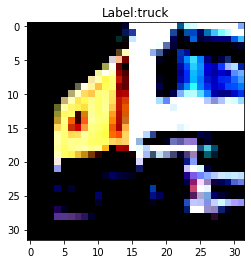

Label of this image: 9 truck
Start training...
epoch: 1 / global_steps: 391
training dataset average loss: 1.485
training_time: 0.36 minutes
validation dataset accuracy: 55.22
epoch: 2 / global_steps: 782
training dataset average loss: 1.070
training_time: 0.78 minutes
validation dataset accuracy: 63.17
epoch: 3 / global_steps: 1173
training dataset average loss: 0.876
training_time: 1.19 minutes
validation dataset accuracy: 67.73
epoch: 4 / global_steps: 1564
training dataset average loss: 0.752
training_time: 1.61 minutes
validation dataset accuracy: 67.24
epoch: 5 / global_steps: 1955
training dataset average loss: 0.671
training_time: 2.02 minutes
validation dataset accuracy: 71.84
epoch: 6 / global_steps: 2346
training dataset average loss: 0.613
training_time: 2.44 minutes
validation dataset accuracy: 73.82
epoch: 7 / global_steps: 2737
training dataset average loss: 0.575
training_time: 2.85 minutes
validation dataset accuracy: 74.95
epoch: 8 / global_steps: 3128
training datase

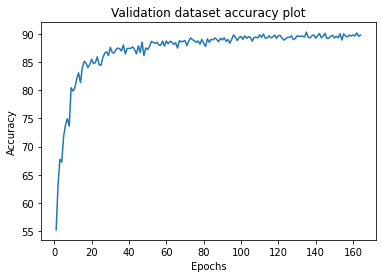

In [0]:
# train model on CIFAR10
# (main training loop)

if __name__ == '__main__':
    # configuration
    cfg = Config()

    print('[CIFAR10_training]')
    print('Training with:', cfg.modelname)
    # GPU 사용이 가능하면 사용하고, 불가능하면 CPU 활용
    print("GPU Available:", torch.cuda.is_available())
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("Device:", device)
    # GPU 사용시
    # if torch.cuda.is_available():
    #     torch.cuda.device("cuda:2")

    # 데이터 로드
    # CIFAR10 dataset: [3,32,32] 사이즈의 이미지들을 가진 dataset
    train_data, val_data = data_load()

    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    # data 개수 확인
    print('The number of training data: ', len(train_data))
    print('The number of validation data: ', len(val_data))

    # shape 및 실제 데이터 확인
    image, label = train_data[1]
    imgshow(image, label, classes)

    # 학습 모델 생성

    if cfg.modelname == "MLP":
        model = MLP_model()
    if cfg.modelname == "MLP_":
        model = MLP_model()
    elif cfg.modelname == "LeNet5":
        model = LeNet5_model()
    elif cfg.modelname == "LeNet5_":
        model = LeNet5_model()
    elif cfg.modelname == "ResNet32":
        model = ResNet32_model()
    elif cfg.modelname == "ResNet32_":
        model = ResNet32_model()
    else:
        print("Wrong modelname.")
        quit()
    if torch.cuda.is_available():
        model = model.to(device)

    # load saved weights
    LOAD = False
    if LOAD:
      save_path = "./drive/My Drive/Colab Notebooks/DSc/saved_model/setting_4/epoch_1.pth"
      # TODO : 세팅값 마다 save_path를 바꾸어 로드
      checkpoint = torch.load(save_path)
      model.load_state_dict(checkpoint['model_state_dict'])
      epoch = checkpoint['epoch']

      # edit as appropriate
      passed_time = 5.05 * 60
      global_steps = 2346
      val_acc_list = []

      with open('./drive/My Drive/Colab Notebooks/DSc/saved_model/setting_4/val_acc', 'r') as f:
        for line in f:
          val_acc = float(line)
          val_acc_list.append(val_acc)
          epoch += 1

      highest_val_acc = max(val_acc_list)

    else:
      passed_time = 0
      epoch = 0
      global_steps = 0
      val_acc_list = []
      highest_val_acc = 0

    # 배치 생성
    train_batch_loader, val_batch_loader = generate_batch(train_data, val_data)
    criterion = nn.CrossEntropyLoss()

    if cfg.modelname == "MLP":
        ###############################################################################################################
        #                  TODO : 모델 학습을 위한 optimizer 정의                                                       #
        ###############################################################################################################
        optimizer = optim.SGD(model.parameters(), lr=cfg.lr, momentum=cfg.momentum, weight_decay=cfg.weight_decay)
        decay_epoch = [32000, 48000]
        step_lr_scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=decay_epoch, gamma=0.1)
        ###############################################################################################################
        #                                              END OF YOUR CODE                                               #
        ###############################################################################################################

    elif cfg.modelname == "LeNet5":
        ###############################################################################################################
        #                  TODO : 모델 학습을 위한 optimizer 정의                                                       #
        ###############################################################################################################
        optimizer = optim.SGD(model.parameters(), lr=cfg.lr, momentum=cfg.momentum, weight_decay=cfg.weight_decay)
        decay_epoch = [32000, 48000]
        step_lr_scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=decay_epoch, gamma=0.1)
        ###############################################################################################################
        #                                              END OF YOUR CODE                                               #
        ###############################################################################################################
    elif cfg.modelname == "ResNet32":
        optimizer = optim.SGD(model.parameters(), lr=cfg.lr, momentum=cfg.momentum, weight_decay=cfg.weight_decay)
        decay_epoch = [32000, 48000]
        step_lr_scheduler = lr_scheduler.MultiStepLR(optimizer,
                                                     milestones=decay_epoch, gamma=0.1)
    elif cfg.modelname == "MLP_":
        optimizer = optim.Adam(model.parameters()) # initial lr = 0.001, no weight decay
        # Note: no learning rate scheduler was used for MLP_

    elif cfg.modelname == "LeNet5_":
        optimizer = optim.Adam(model.parameters()) # initial lr = 0.001, no weight decay
        # factor arbitrarily selected since log 0.001 / log 0.5 = 9.96578428466 meaning approximately 10 * 5 = 50 epochs without improvement in total.
        step_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=5)

    elif cfg.modelname == "ResNet32_":
        optimizer = optim.Adam(model.parameters()) # initial lr = 0.001, no weight decay
        # factor arbitrarily selected since log 0.001 / log 0.5 = 9.96578428466 meaning approximately 10 * 5 = 50 epochs without improvement in total.
        step_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=5)

    # training 시작
    start_time = time.time()
    # (some variables moved)

    print('========================================')
    print("Start training...")
    while True:
        train_loss = 0
        train_batch_cnt = 0
        model.train()
        for img, label in train_batch_loader:
            global_steps += 1
            # img.shape: [batch_size,3,32,32]
            # label.shape: [batch_size]

            img = img.to(device)
            label = label.to(device)
            optimizer.zero_grad()
            outputs = model(img)
            loss = criterion(outputs, label)
            loss.backward()
            optimizer.step()

            train_loss += loss

            train_batch_cnt += 1
            #quit()
            if global_steps >= 64000:
                print("Training finished.")
                break

        ave_loss = train_loss / train_batch_cnt
        # time modified to allow addition of original run time
        training_time = ((time.time() - start_time) + passed_time) / 60
        print('========================================')
        print("epoch:", epoch + 1, "/ global_steps:", global_steps)
        print("training dataset average loss: %.3f" % ave_loss)
        print("training_time: %.2f minutes" % training_time)

        # validation (for early stopping)
        correct_cnt = 0
        model.eval()
        for img, label in val_batch_loader:
            img = img.to(device)
            label = label.to(device)
            pred = model.forward(img)
            _, top_pred = torch.topk(pred, k=1, dim=-1)
            top_pred = top_pred.squeeze(dim=1)
            correct_cnt += int(torch.sum(top_pred == label))

        val_acc = correct_cnt / len(val_data) * 100
        print("validation dataset accuracy: %.2f" % val_acc)
        
        # write val_acc to file for graphing
        with open('./drive/My Drive/Colab Notebooks/DSc/saved_model/setting_4/val_acc', 'a') as f:
          f.write(str(val_acc))
          f.write('\n')

        val_acc_list.append(val_acc)
        if val_acc > highest_val_acc:
            save_path = './drive/My Drive/Colab Notebooks/DSc/saved_model/setting_4/epoch_' + str(epoch + 1) + '.pth'
            # 위와 같이 저장 위치를 바꾸어 가며 각 setting의 epoch마다의 state를 저장할 것.
            torch.save({'epoch': epoch + 1,
                        'model_state_dict': model.state_dict()},
                       save_path)
            highest_val_acc = val_acc
        epoch += 1
        if global_steps >= cfg.finish_step:
            break

    epoch_list = [i for i in range(1, epoch + 1)]
    plt.title('Validation dataset accuracy plot')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(epoch_list, val_acc_list)
    plt.show()


164


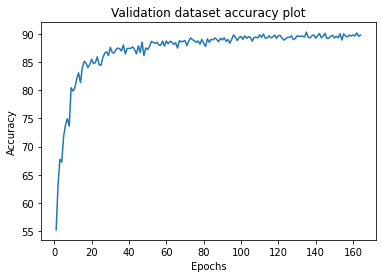

In [0]:
# load validation accuracy and plot the graph required
epoch = 0
val_acc_loaded_list = []

with open('./drive/My Drive/Colab Notebooks/DSc/saved_model/setting_4/val_acc', 'r') as f:
  for line in f:
    val_acc = float(line)
    val_acc_loaded_list.append(val_acc)
    epoch += 1

print(epoch)
epoch_list = [i for i in range(1, epoch + 1)]
plt.title('Validation dataset accuracy plot')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(epoch_list, val_acc_loaded_list)
plt.show()

In [0]:
# evaluate model

import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
def data_load():

    # CIFAR10 dataset 다운로드
    transforms_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    test_data = dsets.CIFAR10(root='./dataset/', train=False, transform=transforms_test, download=True)
    return test_data


def generate_batch(test_data):
    test_batch_loader = DataLoader(test_data, cfg.batch_size, shuffle=True)
    return test_batch_loader


if __name__ == "__main__":
    print('[CIFAR10_evaluation]')
    cfg = Config()

    # GPU 사용이 가능하면 사용하고, 불가능하면 CPU 활용
    print("GPU Available:", torch.cuda.is_available())
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("device:", device)
    # GPU 사용시
    if torch.cuda.is_available():
        torch.cuda.device(0)

    # 모델 생성
    if cfg.modelname == "MLP":
        model = MLP_model()
    elif cfg.modelname == "LeNet5":
        model = LeNet5_model()
    elif cfg.modelname == "ResNet32":
        model = ResNet32_model()
    else:
        print("Wrong modelname.")
        quit()

    if torch.cuda.is_available():
        model = model.to(device)

    model.eval()

    # 데이터 로드
    test_data = data_load()

    # data 개수 확인
    print('The number of test data: ', len(test_data))

    # 배치 생성
    test_batch_loader = generate_batch(test_data)

    # test 시작
    acc_list = []


    # 저장된 state 불러오기
    save_path = "./drive/My Drive/Colab Notebooks/DSc/saved_model/setting_4/epoch_135.pth"
    # TODO : 세팅값 마다 save_path를 바꾸어 로드
    checkpoint = torch.load(save_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    epoch = checkpoint['epoch']
    correct_cnt = 0
    for img, label in test_batch_loader:
        img = img.to(device)
        label = label.to(device)
        pred = model.forward(img)
        _, top_pred = torch.topk(pred, k=1, dim=-1)
        top_pred = top_pred.squeeze(dim=1)

        correct_cnt += int(torch.sum(top_pred == label))

    accuracy = correct_cnt / len(test_data) * 100
    print("accuracy of the n epoch trained model:%.2f%%" % accuracy)
    acc_list.append(accuracy)




[CIFAR10_evaluation]
GPU Available: True
device: cuda
Wrong modelname.
Files already downloaded and verified
The number of test data:  10000
accuracy of the n epoch trained model:90.26%

